<font color='green' size=6 > Temperatura bajo escenarios de probabilidad

Elaborado por **Kevin Campos Sánchez**

Curso: Evaluación, vigilancia y estimación del riesgo climático

Ciclo académico 2022-II.

Universidad Nacional Agraria La Molina, Lima-Perú

### Preparación de entorno

In [210]:
import warnings # Omitir mensajes de advertencia
warnings.filterwarnings("ignore")

##### CONFIGURACIÓN DE ENTORNO #####
from google.colab import drive     # Conectar a Google drive
drive.mount('/content/drive/')

import os

path = '/content/drive/MyDrive/Trabajos_UNALM/EVERC/'  # Directorio de trabajo (cambiar aquí)
os.chdir(path)    # Establecer carpeta de trabajo

import numpy as np, pandas as pd, xarray as xr, matplotlib.pyplot as plt, seaborn as sns
from scipy.stats import norm    # Temperatura se ajusta a una distribución normal
from datetime import datetime

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


Prueba - temperatura bajo una probabilidad "prob"

In [28]:
# Nota: pdf <> pnorm    ppf <> qnorm
mean = 10   # Temperatura media
std = 7     # Desviación estándar

# 1. ¿Cuál es la temperatura con una probabilidad de 5%?
prob = 0.05
value = norm.ppf(prob, loc = mean, scale = std)
print(f'Una P = {prob:.2f} corresponde a una T = {value:.2f}')

# 2. ¿Cuál es la temperatura con una probabilidad de 13%?
prob = 0.13
value = norm.ppf(prob, loc = mean, scale = std)
print(f'Una P = {prob:.2f} corresponde a una T = {value:.2f}')

Una P = 0.05 corresponde a una T = -1.51
Una P = 0.13 corresponde a una T = 2.12


### Datos grillados: PISCOtn v1.1 a nivel mensual

Source: https://iridl.ldeo.columbia.edu/SOURCES/.SENAMHI/.HSR/.PISCO/

In [247]:
# Lectura
Tn = xr.open_dataarray(path + 'PISCO_monthly/PISCOtnm_1.1.nc', decode_times = False)
Tn['T'] = pd.date_range('1981-01-01','2016-12-31', freq = 'MS')
Tn

<xarray.DataArray 'tmin' (T: 432, Y: 202, X: 145)>
[12653280 values with dtype=float32]
Coordinates:
  * X        (X) float32 -81.45 -81.35 -81.25 -81.15 ... -67.25 -67.15 -67.05
  * T        (T) datetime64[ns] 1981-01-01 1981-02-01 ... 2016-11-01 2016-12-01
  * Y        (Y) float32 1.35 1.25 1.15 1.05 ... -18.45 -18.55 -18.65 -18.75
Attributes:
    long_name:       Minimum Temperature
    units:           Celsius_scale
    ncolor:          254
    colormap:        [null 7208960 7208960 8519680 [8519680 15] 11146260 [111...
    maxncolor:       254
    colorscalename:  temp_colors

In [236]:
month = 2       # n° de mes (cambiar aquí)
prob = 0.95     # Escenario de probabilidad (cambiar aquí)

# Período de referencia para calcular medias y desviaciones
periods = [1981,2010]   # Período climatológico: 1981-2010

date_o = datetime(periods[0], month, 1) # Mes inicial
date_f = datetime(periods[1], month, 1) # Mes final

def prob_value_temp(da, p = 0.9):
    """ Devuelve el valor de T correspondiente al valor de probabilidad p """
    loc = np.mean(da)  
    scale = np.std(da, ddof = 1)
    return norm.ppf(p, loc, scale)

P = xr.apply_ufunc(prob_value_temp,     # Función (da, p)
                   Tn.sel(T =  slice(date_o, date_f, 12)),  # da: dataarray
                   prob,                                    # p: probabilidad
                   input_core_dims = [ ['T'], [] ],         # dimensión por argumento
                   vectorize = True)                        # Operación vectorizada

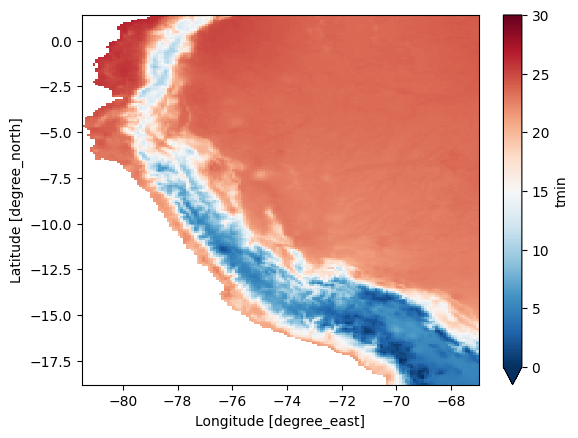

In [246]:
P.plot(cmap = 'RdBu_r', vmin = 0, vmax = 30)